<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/meerkat_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meerkat Preprocessing

In this script, I am preprocessing audio data so that I can reproduce the unsupervised clustering analysis performed by Gentner et al. 2019 (https://www.biorxiv.org/content/10.1101/870311v1.full.pdf) with meerkat vocalizations. I am planning to use the functions made available by Tim Sainsberg (https://github.com/timsainb/avgn_paper), a package called AVGN that should allow me to reproduce the analyses in the paper. Therefore, I need to bring my data into the format that is necessary to run the AVGN analysis functions.

## Prerequisites

- Project folder should already exist, save path as PROJECT_PATH
- Project folder must contain subfolder called "in_labels", containing all label tables in csv format 
- Project folder must contain subfolder called "in_wavs", containing all audio files

### Mounting drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Or select "Mount Drive" in Files menu!

### Installing and loading libraries

(software installations within Google Colaboratory are not persistent, need to reinstall libraries every time you (re-)connect to an instance)

In [2]:
import os
os.system('pip install pydub') # need to install
import pandas as pd
import sys
import re
import json
from IPython.display import Audio 
os.system('pip install "librosa==0.7.1"')
import librosa
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
import statistics
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install noisereduce') # need to install
import noisereduce as nr
os.system('pip install pathlib2') # need to install
import pathlib2
import psutil
import re
import datetime
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Setting constants

Setting project, input and output folders.

In [0]:
# these directories should already exist
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
AUDIO_IN = PROJECT_PATH+"in_wavs/" 
LABELS_IN = PROJECT_PATH+"in_labels/" 

# these directories are created during execution
LABELS_OUT = PROJECT_PATH+"labels/"
FIGURES = PROJECT_PATH+"figures/"

dirs2create = [LABELS_OUT, FIGURES]

# Manual encoding of the meerkat_channels for the SOUNDFOC files
os.chdir(PROJECT_PATH)
MEERKAT_CHANNEL = json.load( open( "meerkat_channel.json" ) )

# Serialize data into file:
# json.dump(meerkat_channel, open( "meerkat_channel.json", 'w' ) )

Constants for parsing label files:

- column names in labels CSV that indicate start and duration
- irrelevant labels that are discarded in the process (labels for beeps, noise, synch calls..)
- minimum and maximum call duration in s

In [0]:
START_COL = 'Start'
DUR_COL = 'Duration'

IRRELEVANT_LABELS = ['SYNCH', 
                     'START', 
                     'END',
                     'STOP',
                     'SKIP', 
                     'NOISE', 
                     'BEEP', 
                     'CHEW',
                     'X',
                     'HYB',
                     'HYBRID',
                     'UKN',
                     'UNKNOWN',
                     'FU',
                     'LOST',
                     'OTHER',
                     'OTH',
                     'LC',
                     'SQ',
                     'STOP',
                     'SKIP',
                     'NF',
                     'NONFOC']
                     
IRRELEVANT_LABELS = IRRELEVANT_LABELS+[item.lower() for item in IRRELEVANT_LABELS]

MAX_DURATION=0.5
MIN_DURATION = 0.05
GROUP = 'HM'

### Installing AVGN

Cloning the AVGN_paper repository:

In [5]:
os.chdir(PROJECT_PATH)

if (not os.path.exists(PROJECT_PATH+'avgn_paper')):
  print("Cloning Repo")
  os.mkdir("avgn_paper")
  os.chdir("avgn_paper")
  os.sytem('git clone https://github.com/timsainb/avgn_paper.git')
else:
  print("Repo already present")
  os.chdir("avgn_paper")

Repo already present


In [6]:
os.system('python setup.py develop')

0

In [0]:
from importlib.machinery import SourceFileLoader
avgn = SourceFileLoader('avgnpaper/avgn', PROJECT_PATH+'avgn_paper/avgn/'+'utils/__init__.py').load_module()
import avgn

### Creating output directories

In [0]:
os.chdir(PROJECT_PATH)

for dirpath in dirs2create:
  if not os.path.exists(os.path.basename(dirpath[:-1])):
    os.mkdir(os.path.basename(dirpath[:-1]))

## Functions

What I need are spectrograms for each meerkaat vocalization. What I have are long .wav files, containing many vocalizations and periods of silence (noise), and a label file (CSV) indicating at what time vocalisations occur (and what type of vocalisation they are). 

### General

In [0]:
# Function that gets fileID from csv filename
# Input: csv_filename (not path!) (String)
# Output: csv_filename up to the last numeric character

def fileID_from_csv_filename(csv_in):
  csv_in = csv_in[::-1]  # reverse string
  def rem_nonnumeric(str): # removes everything up to the first numeric char
    foundDigit=False
    pos=0
    for char in str:
      if(char.isdigit()):
        return(str[pos:])
      pos=pos+1
    return str 
  csv_out = rem_nonnumeric(csv_in)
  csv_out = csv_out[::-1] # reverse to normal again
  return (csv_out)

### Functions for preparing label files

First, I'll parse the csv label files into a pandas dataframe. Then, because PyDub segments audio in milliseconds, I have to turn the format h:min:s.ms to ms, so that I have the start and stop times of the calls in milliseconds (f.e. 10032002-10032144)

In [0]:
# Function that gets datatime object from timestring
# timestring must match one of the given time_patterns
# Input: some string containing a time (String)
# Output: datetime object
# Example usage: dt = get_time("01:02:30.555")
def get_time(timestring):
    time_patterns = ['%H:%M:%S.%f', '%M:%S.%f']
    for pattern in time_patterns:
        try:
            return datetime.datetime.strptime(timestring, pattern)
        except:
            pass

    print("Date is not in expected format")
    
    sys.exit(0)

# Function that converts time in datatime object to s 
# Input: datatime (datatime.datatime)
# Output: time in ms (float)
# Example usage: s = get_s(datatime_obj)
def get_s(dt):
  return dt.microsecond/1000000+dt.second + dt.minute*60 + dt.hour*60*60
  
  
# Function to get the meerkat ID (alphanumeric String) from filename
# filename is always HM_meerkatID_*.extension
# Input: filename (String)
# Output: meerkat ID (String)
# Example use: get_meerkatID('HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102.wav')

def get_meerkatID(filename):
  meerkatID = filename.replace(GROUP+'_','')
  meerkatID = str.split(meerkatID, sep='_')[0]
  return meerkatID

# Function to get date from filename
# date in filename must be in one of the three patterns
# Input: filename (String)
# Output: datetime object
# Example use: get_datetime('HM_VHMF001_HTB_R20_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944')

def get_datetime(filename):
  match = re.search('\d{4}-\d{2}-\d{2}', filename)
  if (match):
    #date = datetime.strptime(match.group(), '%Y-%m-%d').date()
    date = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()
  else:
    match = re.search('\d{4}_\d{2}_\d{2}', filename)
    if (match):
     #date = datetime.strptime(match.group(), '%Y_%m_%d').date() 
     date = datetime.datetime.strptime(match.group(), '%Y_%m_%d').date() 

    else:
      match = re.search('\d{4}\d{2}\d{2}', filename)
      if(match):
        #date = datetime.strptime(match.group(), '%Y%m%d').date()
        date = datetime.datetime.strptime(match.group(), '%Y%m%d').date()
  return date


# Function that produces a labeltable from given csv+wav pairing
# Input: csv_file location (String), wav_file location (String), fileID (String)
# Output: labeltable (pd dataframe)

def prep_labels(csv_loc, wav_loc, fileID):

  # read in labels
  labels = pd.read_csv(csv_loc, sep="\t")

  # find name of column that contains the labels. Should contain 'Name'
  name_col = [col for col in labels.columns if 'Name' in col]
  if(len(name_col)==1):
    name_col = name_col[0]
    call = ["n" if any(s in i for s in IRRELEVANT_LABELS) else "y" for i in list(labels[name_col])]
    labels['call_yn'] = call
  else:
    print("Cannot find label name column")
  
  # Add start stop s
  if (labels.shape[0]!=0):
    labels['start_s'] = labels.apply(lambda row: get_s(get_time(row['Start'])), axis=1)
    labels['duration_s'] = labels.apply(lambda row: get_s(get_time(row['Duration'])), axis=1)
    labels['stop_s'] = labels['start_s']+labels['duration_s']

    # Add additional data
    labels['date']=[get_datetime(fileID).strftime("%Y-%m-%d")]*labels.shape[0]
    labels['samplerate_hz'] = [librosa.get_samplerate(wav_loc)]*labels.shape[0]
    labels['indv'] = [get_meerkatID(fileID)]*labels.shape[0]
    labels["original_wav"] = [wav_loc]*labels.shape[0]
    labels["bout_number"] = [i for i in range(labels.shape[0])]

  labels = labels.rename(columns={name_col: 'Name'})

  return labels

### Functions for creating spectrograms

In [0]:
# Function that gets audio data (numpy array of amplitude) from wav
# If "SOUNDFOC" is in filename, assumes that audio is stereo and 
# looks up the channel with meerkat vocalizations in MEERKAT_CHANNEL dictionary.
# Else assumes mono.
# Input: Path to wav file (String),
#        offset in s (Float),
#        duration in s (Float)
# Output: Amplitude (numpy array)

def get_audio(wav_loc, start_s, duration_s):
  # SOUNDFOCs are stereo
  if "SOUNDFOC" in wav_loc:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
  else:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

  if np.issubdtype(type(data[0]), np.integer):
    data = int16_to_float32(data)
  return data


# Function that generates mel spectrogram from audio data
# Input: data: Audio data (np array of floats), 
#        rate: samplerate in Hz (integer)
#        n_mels: number of mel bands (integer)
#        window: spectrogram window generation type (String)
#        fft_win: window length in s (float)
#        fft_hop: hop between window start in s (float)
# Output: Spectrogram (np array of floats)

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = 4000, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)
    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro

# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

## Processing files

### Setting variables

Getting list of csvs and matching wavs

In [0]:
# Getting list of fileIDs, wavs and csvs (fileID, in_wav_loc and in_csv_loc)

in_csv_loc = glob.glob(LABELS_IN+'*.csv') + glob.glob(LABELS_IN+'*.CSV')
csv_filenames = [os.path.basename(csv) for csv in in_csv_loc]

fileIDs = [fileID_from_csv_filename(csv_filename) for csv_filename in csv_filenames]

in_wav_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
in_wav_loc = [["NA"] if not x else x for x in in_wav_loc] # Replace empty lists with "NA"
in_wav_loc = list(flatten(in_wav_loc)) # Flatten list

### Removing bad quality files

Removing files with bad quality

In [0]:
badIDs = ['HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163', 
           'HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052']

In [0]:
bad_csvs = [glob.glob(LABELS_IN+fileID+'*') for fileID in badIDs]
bad_csvs = list(flatten(bad_csvs))

bad_wavs = []
for bad_csv in bad_csvs:
  bad_wavs.append(in_wav_loc[in_csv_loc.index(bad_csv)])

for bad_csv in bad_csvs:
  in_csv_loc.remove(bad_csv)
for bad_wav in bad_wavs:
  in_wav_loc.remove(bad_wav)
for badID in badIDs:
  fileIDs.remove(badID)


In [295]:
print(str(len(fileIDs))+" files remaining") # all files

114 files remaining


### Generating label files

In [299]:
for csv, wav, fileID in zip(in_csv_loc, in_wav_loc, fileIDs):
  if not wav=='NA':
    print("Processing "+fileID)
  # Parse labels
    labels = prep_labels(csv, wav, fileID)  
    # If labels is non-empty...
    if (labels.shape[0]!=0):
      labels.to_csv(LABELS_OUT+fileID+"_labels.csv", index=False)
    else:
      print("No labelled calls for "+fileID)
  else:
    print("No wav for "+fileID)

Processing HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102
Processing HM_VLF206_SOUNDFOC_20170825_2
Processing HM_VHMM003_SOUNDFOC_20170825_2
Processing HM_VHMM003_SOUNDFOC_20170825_3
Processing HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110
Processing HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092
Processing HM_HTB_R14_file_6_(2017_08_25-06_44_59)_ASWMUX221052
Processing HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163
Processing HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221163
Processing HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102
Processing HM_VLF206_SOUNDFOC_20170824_1
Processing HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163
Processing HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110
Processing HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092
Processing HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110
Processing HM_VLF206_SOUNDFOC_20170823_1
Processing HM_RT_R12_

In [300]:
print("Generated "+str(len(glob.glob(LABELS_OUT+'*')))+" label files") # all

Generated 108 label files


### Get updated list of wav and labels file locations

In [0]:
# List of all wav filepaths (to full wav files, not just the calls), where I have 
# a labels file in LABELS_OUT. Therefore, do it kind of backwards.

labels_loc = glob.glob(LABELS_OUT+'*.csv')
fileIDs = [os.path.basename(item).replace('_labels.csv', '') for item in labels_loc] 

wavs_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
wavs_loc = [["NA"] if not x else x for x in wavs_loc] # Replace empty lists with "NA"
wavs_loc = list(flatten(wavs_loc)) # Flatten list

# check for NAs, should be none!
for ID, wav in zip(fileIDs, wavs_loc):
  if wav=="NA":
    print("Error, wav file missing for"+label)


### Make a dataset dataframe

In [302]:
df_list=[]

for label_loc in labels_loc:
  print("Generating label df for "+os.path.basename(label_loc))
  df_list.append(pd.read_csv(label_loc))

df = pd.concat(df_list)

Generating label df for HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102_labels.csv
Generating label df for HM_VLF206_SOUNDFOC_20170825_2_labels.csv
Generating label df for HM_VHMM003_SOUNDFOC_20170825_2_labels.csv
Generating label df for HM_VHMM003_SOUNDFOC_20170825_3_labels.csv
Generating label df for HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_labels.csv
Generating label df for HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092_labels.csv
Generating label df for HM_HTB_R14_file_6_(2017_08_25-06_44_59)_ASWMUX221052_labels.csv
Generating label df for HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163_labels.csv
Generating label df for HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221163_labels.csv
Generating label df for HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labels.csv
Generating label df for HM_VLF206_SOUNDFOC_20170824_1_labels.csv
Generating label df for HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX2

In [0]:
df.index = list(range(0,df.shape[0]))

In [304]:
df.shape 

(46009, 16)

### Cleaning dataset

#### Categorizing label groups

In [305]:
df['Name'].unique()

array(['START', 'BEEP 1:00:00', 'SYNCH 1:00:00', ..., 'CCX   ',
       'SYNCH 1:48:00?', 'HYB (SOC+CC)'], dtype=object)

In [0]:
lablenames = df['Name']

In [0]:
call_types = {
    'cc' :["cc","Marker", "Marque", "CC", "MARKER", "MARQUE"],
    'sn' :["sn","subm", "short","^s$", "s ", "SN", "SUBM", "SHORT", "S"], 
    'mo' :["mo", "mov", "move", "MO","MOV","MOVE"],
    'agg':["ag", "agg", "aggress", "chat", "growl","AG","AGG","AGGRESS","CHAT","GROWL"],
    'ld' :["ld","LD","lead","LEAD"],
    'soc':["soc","SOCIAL", "so ", "SOC", "social"],
    'al' :["al", "AL","ALARM", "alarm"],
    }
    
# make dictionary labels to calls
labels_to_calls = dict((v,k) for k in call_types for v in call_types[k])

- Remove all that contain # (unsure if it's even a call)

In [0]:
lablenames = ["other" if '#' in i else i for i in lablenames]

- Remove noisy calls (marked with "X" or "x")

In [0]:
lablenames = ["other" if (('x' in i) or ('X' in i)) else i for i in lablenames]

- Remove "?", "!","*" and "%" (? expresses uncertainty about label, * expresses uncertainty about nonfocal or focal, don't know what ! means, % means overlapping calls)

In [0]:
labelsep = re.compile('[\?\*\!%]') # Match ? * ! %
lablenames = [labelsep.sub('', i) for i in lablenames]

- String split and use first word for categorization based on dictionary

In [0]:
firstword = [i.split(' ')[0] for i in lablenames]
lables = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in firstword]

Write to df

In [0]:
df['call_lable'] = lables

In [0]:
df.to_pickle(PROJECT_PATH+"df_all")

#### Removing long and short calls

(array([3.5916e+04, 6.5160e+03, 8.7000e+02, 3.1100e+02, 2.0100e+02,
        3.5200e+02, 4.1600e+02, 2.8800e+02, 1.2800e+02, 1.5800e+02,
        2.4000e+02, 2.9500e+02, 2.7500e+02, 2.8000e+01, 3.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

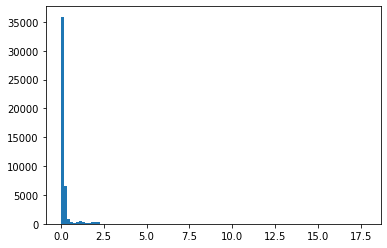

In [318]:
plt.hist(df['duration_s'], bins=100)

In [319]:
df = df.loc[df['duration_s'] <= MAX_DURATION]
df.shape

(43198, 17)

In [320]:
df = df.loc[df['duration_s'] >= MIN_DURATION]
df.shape

(33796, 17)

In [0]:
df.to_pickle(PROJECT_PATH+"df_all_clean") # (33796, 17)

### Creating the spectrograms

Creating spectrograms from call files and put them as numpy array into labels dataframe. First, remove all signals that are not calls and all calls that are too short.



In [0]:
df = pd.read_pickle(PROJECT_PATH+"df_all_clean")

Update call_yn

In [0]:
call = df['call_lable']!="unknown"
call_yn = ['y' if x else 'n' for x in call]

In [0]:
df['call_yn'] = call_yn

Select only calls

In [325]:
spec_df = df.loc[df['call_yn']=="y"]
spec_df.shape

(27244, 17)

In [0]:
spec_df.index = list(range(0,spec_df.shape[0]))

#### Setting parameters

In [0]:
FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients

#### Getting audio data

In [0]:
raw_audio_data = spec_df.apply(lambda row: get_audio(row['original_wav'], row['start_s'], row['duration_s']), axis=1)
spec_df['raw_audio'] = raw_audio_data

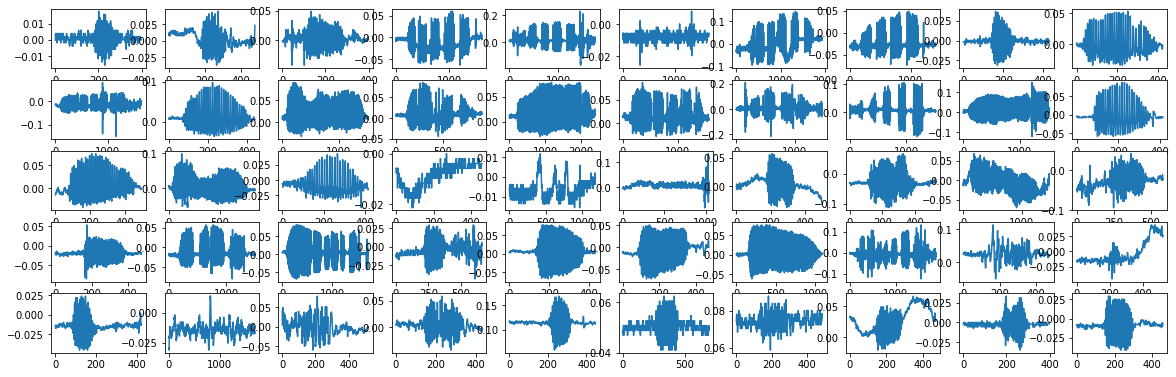

In [335]:
subset_df = spec_df.loc[0:50,]
sylls = subset_df.raw_audio.values

nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

#### Spectrogramming

In [0]:
spectrograms = spec_df.apply(lambda row: generate_mel_spectrogram(row['raw_audio'], 
                                                             row['samplerate_hz'], 
                                                             N_MELS, 
                                                             WINDOW, 
                                                             FFT_WIN , 
                                                             FFT_HOP), 
                        axis=1)

spec_df['spectrograms'] = spectrograms

Visualize the first 50 spectrograms

In [0]:
from avgn.visualization.spectrogram import draw_spec_set

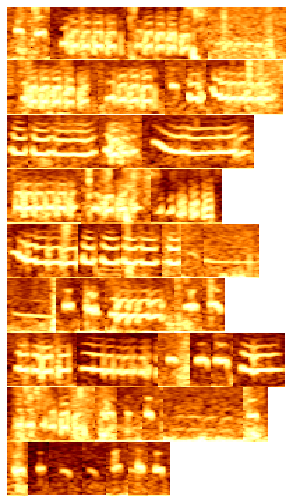

In [338]:
df_subset = spec_df.iloc[1:50,]
specs = df_subset.spectrograms.values
draw_spec_set(specs, zoom=1, maxrows=10, colsize=5)
plt.show()

#### MFCCs

In [0]:
mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in spec_df['spectrograms']]
spec_df['mfccs'] = mfccs

#### MFCC Deltas

In [0]:
mfcc_deltas = [librosa.feature.delta(mfcc) for mfcc in spec_df['mfccs']]
spec_df['mfcc_deltas'] = mfcc_deltas

#### MFCC Delta-Deltas

In [0]:
mfcc_deltadeltas = [librosa.feature.delta(mfcc, order=2) for mfcc in spec_df['mfccs']]
spec_df['mfcc_deltadeltas'] = mfcc_deltadeltas

### Save dataframe

Add soundfoc_yn

In [0]:
ori_wav = spec_df['original_wav']
soundfoc_yn = ['y' if "SOUNDFOC" in i else 'n' for i in ori_wav]
spec_df['soundfoc_yn'] = soundfoc_yn

Sort

In [0]:
spec_df = spec_df.sort_values(by=['original_wav', 'bout_number'])

In [0]:
spec_df.to_pickle('spec_df_all')

# UMAP projection

### Preparation

In [11]:
import umap
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Choose dataset

In [0]:
# Full df with soundfoc and non soundfoc data
df = pd.read_pickle(PROJECT_PATH+"spec_df_all")

#
#df = pd.read_pickle(PROJECT_PATH+'spec_df_all_stretch')

Set spec_df to desired dataset

In [0]:
# A) Full
spec_df = df
dftype='full'

In [0]:
# B) Partial
spec_df = df[df.call_lable != 'cc']
dftype='non_cc'
#spec_df = df[df.soundfoc_yn == 'n']
#dftype='nonfoc'


Choose features

Set specs to desired data and declare method with String. We can use melspectrograms (A) or MFCCs (B). 

In [0]:
# A) Using mel spectrograms:
specs = spec_df.spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'melspectro'

In [0]:
# b) Using MFCCs:
specs = spec_df.mfccs.values
method='mfcc'

In [0]:
#c) Using MFCCs:
specs = spec_df.stretched_mfccs.values
method='stretched_mfcc'

Pad with zeros and normalize

In [0]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)

spectro_data = StandardScaler().fit_transform(pd.DataFrame(specs_arr))
data = spectro_data

In [0]:
flattened_specs = [spec.flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)

spectro_data = StandardScaler().fit_transform(pd.DataFrame(specs_arr))
data = spectro_data

**Optional: Include deltas in feature vector**

Can choose deltas or delta-deltas

In [0]:
# A) MFCC Deltas
deltas = spec_df.mfcc_deltas.values
method =method+'_delta'

In [0]:
# A) MFCC Deltas
#deltas = spec_df.stretched_mfcc_deltas.values
#method =method+'_delta'

In [0]:
# B) MFCC Deltadeltas
deltas = spec_df.mfcc_deltadeltas.values
method =method+'_deltadelta'

Pad and normalize

In [0]:
maxlen= np.max([delta.shape[1] for delta in deltas])
flattened_deltas = [pad_spectro(delta, maxlen).flatten() for delta in deltas]
deltas_arr = np.asarray(flattened_deltas)

delta_data = StandardScaler().fit_transform(pd.DataFrame(deltas_arr))

In [0]:
# for stretched
flattened_deltas = [delta.flatten() for delta in deltas]
deltas_arr = np.asarray(flattened_deltas)

delta_data = StandardScaler().fit_transform(pd.DataFrame(deltas_arr))

Concatenate:

In [0]:
data = np.concatenate((spectro_data, delta_data), axis=1)

### Running UMAP

In [0]:
reducer = umap.UMAP()

In [0]:
embedding = reducer.fit_transform(data)

In [39]:
embedding.shape #(27244, 2) all, (22992, 2) non-foc, (4252, 2) foc

(27244, 2)

### Visualization

In [0]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [0]:
z  = list(embedding)
z = np.vstack(z)

# Use spectrogram examples
specs = spec_df.spectrograms.values
#specs = spec_df.stretched_spectrograms.values

#### By individual

/content/drive/My Drive/meerkat/figures/2020-06-23_mfcc_delta_full_ind


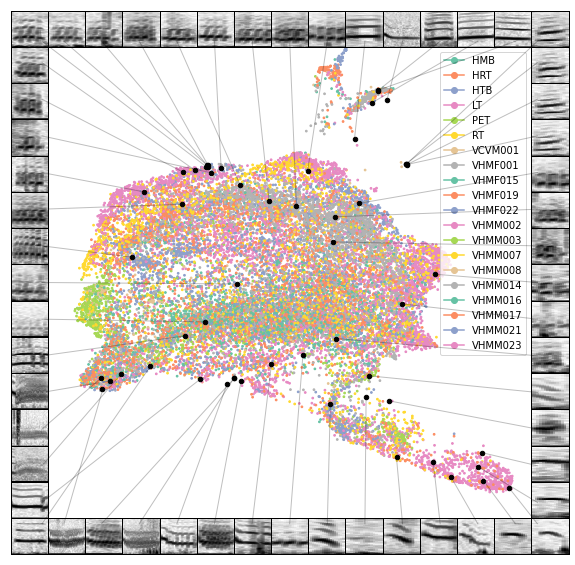

In [214]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.indv.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_ind'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By label

/content/drive/My Drive/meerkat/figures/2020-06-23_stretched_mfcc_delta_non_cc_call


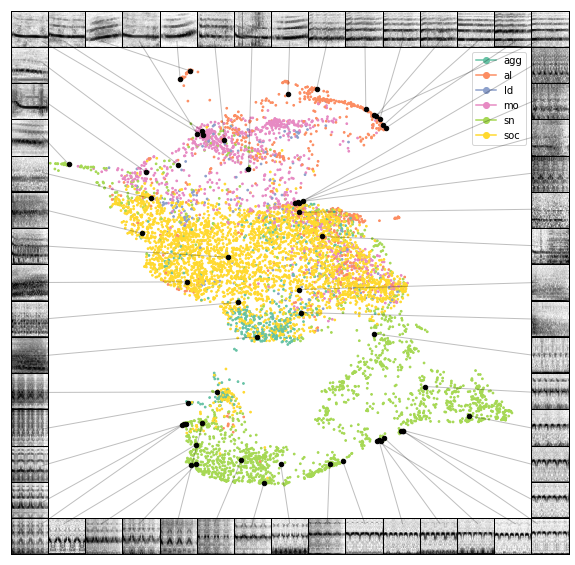

In [80]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.call_lable.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_call'
save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By recording type (focal or nonfocal)

In [0]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.soundfoc_yn.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_soundfoc'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

# Clustering

Cluster the calls into distinct categories based on the UMAP values.

In [310]:
os.system('pip install hdbscan')

0

In [0]:
import hdbscan

In [0]:
data = embedding

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(data) * 0.08), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
    cluster_selection_method='leaf'
)
clusterer.fit(data);

In [0]:
#df['HDBSCAN_labels'] = clusterer.labels_

/content/drive/My Drive/meerkat/figures/mfcc_soundfoc_ind


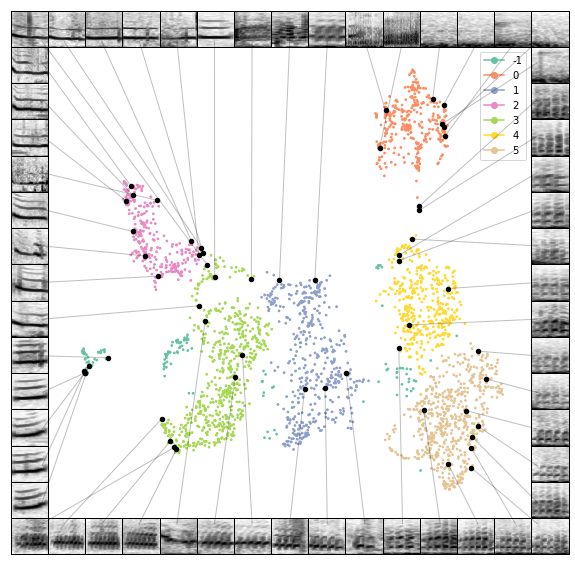

In [316]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': clusterer.labels_,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURES+method+'_'+dftype+'_ind_all', dpi=300, save_jpg=True)
print(FIGURES+method+'_'+dftype+'_ind')

In [0]:
from sklearn.cluster import KMeans

In [0]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(data)

/content/drive/My Drive/meerkat/figures/mfcc_delta_full_ind


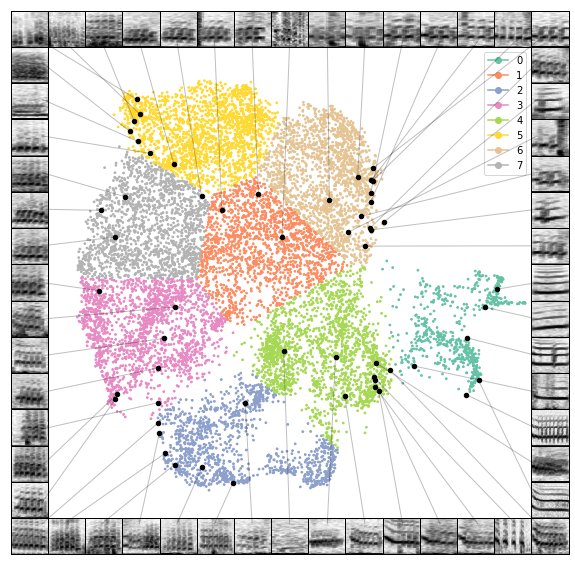

In [118]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': kmeans.labels_,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURES+method+'_'+dftype+'_ind_all', dpi=300, save_jpg=True)
print(FIGURES+method+'_'+dftype+'_ind')

(12234, 1742)

# Time stretch

In [0]:
df = pd.read_pickle(PROJECT_PATH+'df_all')

In [20]:
df.shape

(46009, 17)

In [112]:
max(df.duration_s.values)

17.766

(array([2.559e+03, 6.843e+03, 3.811e+03, 4.829e+03, 6.687e+03, 6.293e+03,
        4.501e+03, 2.594e+03, 1.609e+03, 1.027e+03, 5.900e+02, 4.340e+02,
        3.330e+02, 2.660e+02, 2.030e+02, 1.590e+02, 1.410e+02, 1.170e+02,
        9.200e+01, 1.000e+02, 9.300e+01, 6.200e+01, 5.300e+01, 3.800e+01,
        3.900e+01, 4.800e+01, 3.000e+01, 4.200e+01, 3.600e+01, 2.800e+01,
        3.400e+01, 2.500e+01, 2.600e+01, 2.800e+01, 3.000e+01, 2.800e+01,
        3.100e+01, 5.100e+01, 5.200e+01, 5.800e+01, 7.100e+01, 4.100e+01,
        5.200e+01, 5.000e+01, 4.900e+01, 5.400e+01, 5.100e+01, 6.300e+01,
        7.300e+01, 6.300e+01, 7.000e+01, 5.800e+01, 4.900e+01, 3.900e+01,
        2.500e+01, 2.100e+01, 2.100e+01, 1.900e+01, 1.400e+01, 1.800e+01,
        1.600e+01, 2.400e+01, 2.200e+01, 1.300e+01, 2.600e+01, 2.300e+01,
        2.900e+01, 2.700e+01, 1.700e+01, 2.000e+01, 1.400e+01, 2.500e+01,
        1.900e+01, 3.200e+01, 3.200e+01, 4.500e+01, 4.000e+01, 3.900e+01,
        3.800e+01, 4.400e+01, 5.300e+0

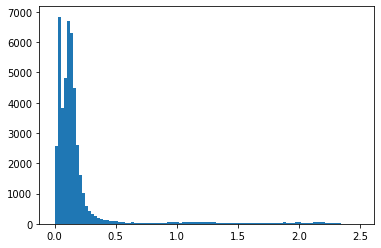

In [121]:
plt.hist(df[df['duration_s']<2.5].duration_s.values, bins=100)

In [129]:
df[df['duration_s']>0.5].shape[0]/df.shape[0] # % of calls > 0.5s

0.061096741941794

I think it doesn't make sense to shorten these 6 % calls that are longer than 0.5s. So I'll use the filtered set (spec_df) and stretch all calls there to the same length, 0.5s.

In [37]:
pyrubberband.__version__

'0.3.0'

In [0]:
def stretch_audio(y,duration):
  rate = duration/MAX_DURATION
  y_out = librosa.effects.time_stretch(y, rate)
  return y_out

In [0]:
def stretch_audio_pyrub(y,duration,sr):
  rate = duration/MAX_DURATION
  y_out = pyrubberband.pyrb.time_stretch(y, sr, rate)
  return y_out

In [0]:
spec_df = pd.read_pickle(PROJECT_PATH+'spec_df_all')

In [0]:
# Get audio
stretched_audio = spec_df.apply(lambda row: stretch_audio(row['raw_audio'],
                                                          row['duration_s']), 
                                axis=1)
spec_df['stretched_audio'] = stretched_audio

In [0]:
# Spectrogramming
spectrograms = spec_df.apply(lambda row: generate_mel_spectrogram(row['stretched_audio'], 
                                                             row['samplerate_hz'], 
                                                             N_MELS, 
                                                             WINDOW, 
                                                             FFT_WIN , 
                                                             FFT_HOP), 
                        axis=1)

spec_df['stretched_spectrograms'] = spectrograms

In [0]:
# MFCCs etc.

mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in spec_df['stretched_spectrograms']]
spec_df['stretched_mfccs'] = mfccs

mfcc_deltas = [librosa.feature.delta(mfcc) for mfcc in spec_df['stretched_mfccs']]
spec_df['stretched_mfcc_deltas'] = mfcc_deltas

In [0]:
mfcc_deltadeltas = [librosa.feature.delta(mfcc, order=2) for mfcc in spec_df['stretched_mfccs']]
spec_df['stretched_mfcc_deltadeltas'] = mfcc_deltadeltas

In [0]:
spec_df.to_pickle(PROJECT_PATH+'spec_df_all_stretch')

# NOISE

In [4]:
%cd noise_files/

/content/drive/My Drive/meerkat/noise_files


In [0]:
%ls

In [0]:
example_ID= 'HM_VHMF001_HTB_R20_20190707-20190719_file_10_(2019_07_16-11_44_59)_165944_labels.csv'

example_ID='HM_HTB_R14_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221052_labels.csv'

example_lable = pd.read_csv(LABELS_OUT+example_ID)


In [94]:
row = 107

window = 2
offset_s = example_lable.loc[row,'start_s']
dur_s = example_lable.loc[row,'duration_s']
example_file = AUDIO_IN+example_ID[:-11]+".wav"

#data, rate = librosa.load(example_file, offset=offset_s-2, duration=dur_s+4, sr=None, mono=False)
data, rate = librosa.load(example_file, offset=offset_s, duration=dur_s, sr=None, mono=False)

Audio(data=data, rate=rate) 

In [0]:
raw_audio = get_audio(example_lable.loc[row,'original_wav'], example_lable.loc[row,'start_s'], example_lable.loc[row,'duration_s'])

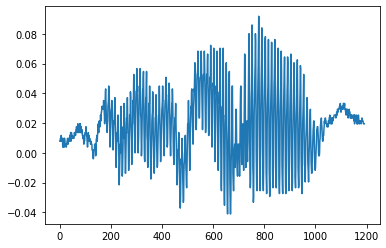

In [96]:
plt.plot(raw_audio)

In [0]:
spectrogram = generate_mel_spectrogram(raw_audio,rate,N_MELS,WINDOW,FFT_WIN,FFT_HOP)

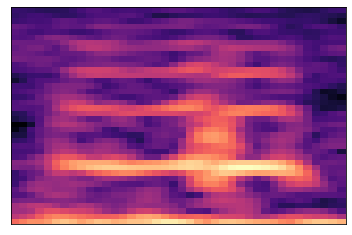

In [98]:
librosa.display.specshow(spectrogram)

In [0]:
example_lable.loc[100:130,]